# Plot training loss and validation loss
This notebook is designed to plot `training loss` and `validation loss` into a single graph via `Seaborn`.  
`training loss` and `validation loss` are fetched from model training script and `eval_dev_loss.py`.  
You should provide the `csv` file path of `training loss` and `validation loss` to draw the figure.  
(It can be downloaded from `tensorboard`)



In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter
import fine_tune

## Set file path of `training loss` and `validation loss`
Here you should set csv file path of `training loss` and `validation loss`, which are downloaded from `tensorboard`.

In [2]:
train_loss_csv_path = 'data/fine_tune_experiment/log/PKD_hidden_user_defined_9_42_bert_qnli/run-PKD_hidden_user_defined_9_42_bert_qnli-tag-qnli_train_bert_logits_loss.csv'
val_loss_csv_path = 'data/fine_tune_experiment/log/PKD_hidden_user_defined_9_42_bert_qnli/run-PKD_hidden_user_defined_9_42_bert_qnli-tag-qnli_dev_bert_loss.csv'

In [3]:
# Load log step from config.
# It is used for plot.
log_step = fine_tune.config.StudentConfig.load(
    experiment='PKD_hidden_user_defined_9_42',
    model='bert',
    task='qnli',
    device_id=0
).log_step
print(log_step)

100


## Load them as `pd.DataFrame`

In [4]:
train_loss = pd.read_csv(train_loss_csv_path)
print(train_loss.head())
print(f'row count of `train_loss`: {len(train_loss.index)}')

      Wall time  Step     Value
0  1.628564e+09   100  2.553557
1  1.628564e+09   200  2.472629
2  1.628564e+09   300  2.733894
3  1.628564e+09   400  2.448380
4  1.628565e+09   500  2.401752
row count of `train_loss`: 261


In [5]:
val_loss = pd.read_csv(val_loss_csv_path)
print(val_loss.head())
print(f'row count of `val_loss`: {len(val_loss.index)}')

      Wall time  Step     Value
0  1.628672e+09     0  2.051143
1  1.628672e+09     1  2.389558
2  1.628672e+09     2  2.232227
3  1.628672e+09     3  2.821109
4  1.628672e+09     4  2.398969
row count of `val_loss`: 288


In [6]:
# If row count dosen't match, truncate to smaller one.
train_row_count = len(train_loss.index)
val_row_count = len(val_loss.index)
if train_row_count > val_row_count:
    # truncate `train_loss`
    train_loss.drop(list(range(val_row_count, train_row_count)), inplace=True)
    print(f'Truncated `train_loss`:\n{train_loss.describe()}')
elif train_row_count < val_row_count:
    val_loss.drop(list(range(train_row_count, val_row_count)), inplace=True)
    print(f'Truncated `val_loss`:\n{val_loss.describe()}')
else:
    print("Don't have to truncate")

Truncated `val_loss`:
          Wall time       Step       Value
count  2.610000e+02  261.00000  261.000000
mean   1.628672e+09  130.00000    2.044703
std    8.620108e-03   75.48841    0.534057
min    1.628672e+09    0.00000    0.793800
25%    1.628672e+09   65.00000    1.718449
50%    1.628672e+09  130.00000    2.048632
75%    1.628672e+09  195.00000    2.322775
max    1.628672e+09  260.00000    4.238034


## Merge two dataframe

In [7]:
# Drop unneccesary columns
train_loss.drop(columns=['Wall time','Step'], inplace=True)
train_loss.rename(columns={'Value':'Distil Loss'}, inplace=True)
val_loss.drop(columns=['Wall time','Step'], inplace=True)
val_loss.rename(columns={'Value':'Distil Loss'}, inplace=True)
print(f'{train_loss=}')
print(f'{val_loss=}')

train_loss=     Distil Loss
0       2.553557
1       2.472629
2       2.733894
3       2.448380
4       2.401752
..           ...
256     0.029715
257     0.130991
258     0.064409
259     0.140099
260     0.036953

[261 rows x 1 columns]
val_loss=     Distil Loss
0       2.051143
1       2.389558
2       2.232227
3       2.821109
4       2.398969
..           ...
256     1.807410
257     1.660223
258     1.999171
259     2.514039
260     1.908645

[261 rows x 1 columns]


In [8]:
# Add a new column for both dataframe
train_loss = train_loss.assign(dataset='Train')
val_loss = val_loss.assign(dataset='Dev')

In [9]:
print(f'train_loss\n{train_loss}')
print(f'val_loss\n{val_loss}')

train_loss
     Distil Loss dataset
0       2.553557   Train
1       2.472629   Train
2       2.733894   Train
3       2.448380   Train
4       2.401752   Train
..           ...     ...
256     0.029715   Train
257     0.130991   Train
258     0.064409   Train
259     0.140099   Train
260     0.036953   Train

[261 rows x 2 columns]
val_loss
     Distil Loss dataset
0       2.051143     Dev
1       2.389558     Dev
2       2.232227     Dev
3       2.821109     Dev
4       2.398969     Dev
..           ...     ...
256     1.807410     Dev
257     1.660223     Dev
258     1.999171     Dev
259     2.514039     Dev
260     1.908645     Dev

[261 rows x 2 columns]


In [10]:
# Assign new `Step` column.
train_loss = train_loss.assign(Step=lambda x: x.index * log_step + log_step)
val_loss = val_loss.assign(Step=lambda x: x.index * log_step + log_step)
print(f'train_loss\n:{train_loss}')
print(f'val_loss\n:{val_loss}')

train_loss
:     Distil Loss dataset   Step
0       2.553557   Train    100
1       2.472629   Train    200
2       2.733894   Train    300
3       2.448380   Train    400
4       2.401752   Train    500
..           ...     ...    ...
256     0.029715   Train  25700
257     0.130991   Train  25800
258     0.064409   Train  25900
259     0.140099   Train  26000
260     0.036953   Train  26100

[261 rows x 3 columns]
val_loss
:     Distil Loss dataset   Step
0       2.051143     Dev    100
1       2.389558     Dev    200
2       2.232227     Dev    300
3       2.821109     Dev    400
4       2.398969     Dev    500
..           ...     ...    ...
256     1.807410     Dev  25700
257     1.660223     Dev  25800
258     1.999171     Dev  25900
259     2.514039     Dev  26000
260     1.908645     Dev  26100

[261 rows x 3 columns]


In [11]:
train_loss['Distil Loss'] = savgol_filter(train_loss['Distil Loss'], 5, 2)
val_loss['Distil Loss'] = savgol_filter(val_loss['Distil Loss'], 5, 2)

In [12]:
# Concate them
summary = pd.concat([train_loss,val_loss], ignore_index=True)
print(summary)

     Distil Loss dataset   Step
0       2.519302   Train    100
1       2.588984   Train    200
2       2.590354   Train    300
3       2.516213   Train    400
4       2.430533   Train    500
..           ...     ...    ...
517     1.558374     Dev  25700
518     1.754963     Dev  25800
519     2.083683     Dev  25900
520     2.136419     Dev  26000
521     2.083370     Dev  26100

[522 rows x 3 columns]


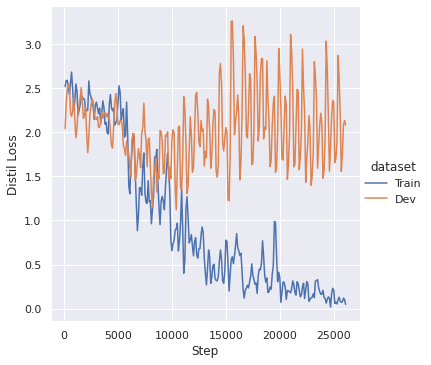

In [13]:
sns.set_theme(style="darkgrid")
sns.relplot(x='Step', y='Distil Loss', kind='line', data=summary, hue='dataset',sort=False)

## (Optional) Save figure as `.png` file

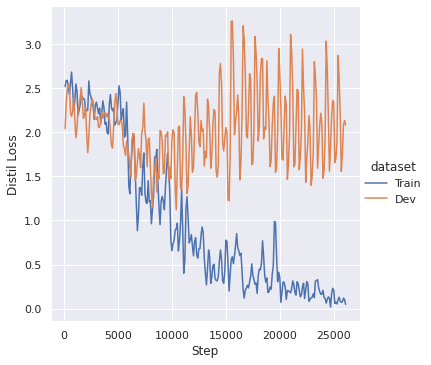

In [14]:
file_name = input("Type in filename:\n")
sns.relplot(x='Step', y='Distil Loss', kind='line', data=summary, hue='dataset',sort=False).savefig(f"{file_name}.png")